In [1]:
import numpy as np
import math

def theta_emp(a: float) -> int:
    value = 0.5100 * a - 1.7312 * math.sqrt(a)
    return max(0, math.ceil(value))

theta_emp(24 + 20)

11

Fitted normal distributions:
  Biological: μ = 29.22, σ = 2.31
  Random:     μ = 29.50, σ = 2.17
  Model-based cutoff (left-tail, FPR=1e-05): 20.25


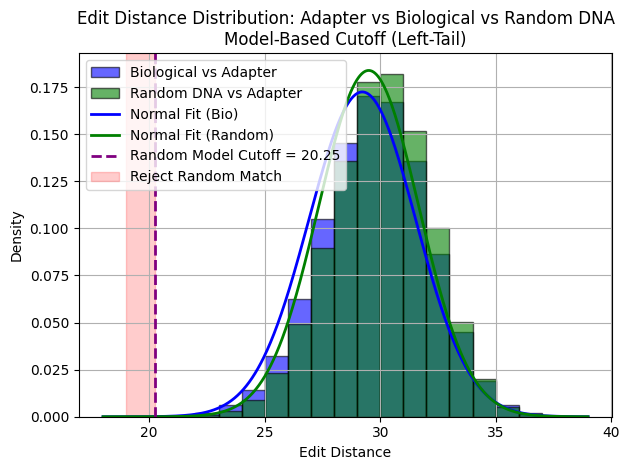

In [41]:
import random
from statistics import mean, stdev
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
from scipy.stats import norm

# Parameters
fasta_file = "/home/solprof/Downloads/coli_genome.fasta"

num_samples = 100000
adapter = "GTTTTCGCATTTATCGTGAAACGCTTTCGCGTTTTTCGTGCGCCGCTTCA"
length = len(adapter)
target_false_positive_rate = 1e-5  # e.g. 1 in 100,000

# Edit distance (Levenshtein)
def edit_distance(s1, s2):
    m, n = len(s1), len(s2)
    dp = list(range(n + 1))
    for i in range(1, m + 1):
        prev, dp[0] = dp[0], i
        for j in range(1, n + 1):
            cur = dp[j]
            if s1[i - 1] == s2[j - 1]:
                dp[j] = prev
            else:
                dp[j] = 1 + min(prev, dp[j - 1], dp[j])
            prev = cur
    return dp[n]

# Random synthetic DNA generator
def random_dna(length):
    return ''.join(random.choices('ACGT', k=length))

# Load genome and extract clean windows
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    seq = str(record.seq).upper()
    if len(seq) >= length:
        sequences.append(seq)

windows = []
for seq in sequences:
    for i in range(len(seq) - length + 1):
        window = seq[i:i+length]
        if set(window).issubset({'A', 'C', 'G', 'T'}):
            windows.append(window)

if not windows:
    raise RuntimeError("No valid genome windows found.")

# Sample distances
bio_distances = []
rand_distances = []
for _ in range(num_samples):
    s1 = random.choice(windows)
    bio_distances.append(edit_distance(s1, adapter))
    s2 = random_dna(length)
    rand_distances.append(edit_distance(s2, adapter))

# Fit normal distributions
mu_bio, sigma_bio = np.mean(bio_distances), np.std(bio_distances)
mu_rand, sigma_rand = np.mean(rand_distances), np.std(rand_distances)

# Compute left-tail cutoff from random model
model_cutoff = norm.ppf(target_false_positive_rate, loc=mu_rand, scale=sigma_rand)

print("Fitted normal distributions:")
print(f"  Biological: μ = {mu_bio:.2f}, σ = {sigma_bio:.2f}")
print(f"  Random:     μ = {mu_rand:.2f}, σ = {sigma_rand:.2f}")
print(f"  Model-based cutoff (left-tail, FPR={target_false_positive_rate}): {model_cutoff:.2f}")

# Prepare plot range
x_range = np.linspace(min(bio_distances + rand_distances),
                      max(bio_distances + rand_distances), 1000)

# Plot histograms
bins = range(min(bio_distances + rand_distances), max(bio_distances + rand_distances) + 1)

plt.hist(bio_distances, bins=bins, alpha=0.6, density=True,
         label='Biological vs Adapter', color='blue', edgecolor='black')
plt.hist(rand_distances, bins=bins, alpha=0.6, density=True,
         label='Random DNA vs Adapter', color='green', edgecolor='black')

# Overlay normal PDF curves
plt.plot(x_range, norm.pdf(x_range, mu_bio, sigma_bio),
         color='blue', linestyle='-', linewidth=2, label='Normal Fit (Bio)')
plt.plot(x_range, norm.pdf(x_range, mu_rand, sigma_rand),
         color='green', linestyle='-', linewidth=2, label='Normal Fit (Random)')

# Add cutoff line
plt.axvline(model_cutoff, color='purple', linestyle='--', linewidth=2,
            label=f'Random Model Cutoff = {model_cutoff:.2f}')

# Highlight rejection region
plt.axvspan(min(rand_distances), model_cutoff, color='red', alpha=0.2,
            label='Reject Random Match')

# Final plot formatting
plt.title("Edit Distance Distribution: Adapter vs Biological vs Random DNA\nModel-Based Cutoff (Left-Tail)")
plt.xlabel("Edit Distance")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
read = "ATGTATCGTTCTTCGTTCATATGTTCAACACATCAGCTGATGCGTTACATACCAAACCTGTTTTCGCATTTATCGTGAAACGCTTTCGCGTTTTTCGTGCGCCGCTTCAGTGGGGAAAACGGCGATTGTAGAAGGCTTGGCACAGCGTATTGTAAACGGCGAAGTGCCGGAAGGCTTGAAAAATAAGCGTGTACTTTCGCTGGATATGGGAGCATTAATTGCCGGTGCGAAATATCGTGGTGAATTTGAAGAGCGTTTAAAAGCGGTTTTAAACGAACTGGCGAAAGAAGAAGGGCAAGTTATCCTCTTTATTGATGAATTTGGCACAATGGTTGGAGCAGGCAAAACAGACGGAGCAATGGACGCCGGCAACTTATTAAAACCAAGCCTTGCCCGTGGTGAATTGCACTGTGTGGGGGCTACAACCCTTGATGAATATCGCCAATACATTGAAAAAGACGCAGCCCTTGAACGCCGTTTCCAAAAAGTATTGGTGGACGAACCAACGGTTGAAATTCAGTACGATTTACGTGGTTTGAAAGAGCGTTATGAAATCCATCATCACGTTCAAATTACGACCCCTGCCATCGTGGCGGCGGCAACGCTTTCGCACCGTTATGTGTCTGACCGTCAATTGCCGGATAAAGCGATTGACTTTGATTGATGAAGCCGCTTCAAGCCTGCGTATGGAGATTGATTCTAAACCTGAGCCGTTGGATAAATTAGAACGCCGCATTATCCAACTCAAATTGGAACGCCAAGCGTTACAAAAAGAGGAAGATGAAGCGAGCCGTCAGCGTTTAGCCAAATTAGACGAAGAAATGGCAGCGAAAGAGCGTGAATATTCCGAGCTGGAAGAAATCTGGAAAGCGGAAAAATCCGCCTTACTTGGTACACAGCATATTAAATCGGAGTTGGAAAATGCCCGAATTGCGATGGATCAGGCTCGCCGTGAAAACGATTTCGAGAAGATGTCGGAATTGCAATATGGCGTGATTCCAAACTTGGAAAAACAGTTACAAGCGGTCGAAAATGGCGAAAAAAATGCAGATGCTCAGCTCCTCCGTACTAAAGTCACCGAAGAGGAAATTGCGGAAGTGCTTTCAAAAGCAACGGGCATTCCTGTTGCAAAAATGATGGAAGGCGAGAAGGAAAAACTTGTTCGTATGGAAGAAGTATTTACGCACGCTGGGTTATCGGGCAAAATAAGAACCATTGATGCGGTGGCAAATGCGATTCGCCGTAGCCGTGCCGGACTTTCCAATCCGAATAAACCGATTGGTTCATTCCTATTCTTAGGACCAAGCCGGCGTGGGTAAAACCGAGTTAAGCAAAACCTTAGCTAATTTCTTGTTTGACAATCCTGATGCTATGGTGCAAATTGATATGTCTGAATTTATGGAAAAACGCAGCGTATCCCGCTTAGTCGGCGCACCTCCGGGCTATGTCGGCTACGAAGAAGGCGGCTATTTGACCGAAGCGGTTCGCCGCCATCCATATTCGGTAGTGCTACTTGATGAAGTGGAAAAAGCTCACCCTGATGTGTTTAACATTTTATTGCAAGTGTTAGATGACGGGCGTTTAACCGACGGGCAAGGCAGAACAGTCGATTTCCGCAATACGGTAGTGATTATGACCTCAAACTTAGGCTCGCATTTAATTCGAGAAAATGCGTATAAAGGCTATGATGTGGTTAAAGAAATGGTGATGGAAGTCGTCGGACAGCACTTCCGCCCTGAATTTATCAACCGTATTGATGAAACGGTGATGTTCCACTCACTTGGTCAAGAGCATATCCGTTCGATTGCGAAGATTCAGCTACAACGCTTAATCCAACGCTTGGCAGAACGAGGCTATGAGGTGACAGTAACCGATGCAGCATTAGATCATATCGGCAAGGCTGGTTTCGATCCGCTGTTCGGAGCAAGACCACTGAAACGTGCGATTCAACAAGAGCTTGAAAATCCGCTTGCTCAACAGATCTTAGCGGTAAATTATTACCGAATAAAGCCGTTACGGTGGATTACCAAAACGGGCAGATTGTTGCAACACAATAATGTCTCCGATGGTGCGAGCGTCCTCGCTCGTACCTTACAAGCGGTGGATTCTCGTAAAAATTTGCAAAAAATTCTCAAAATGACCGCTTGCACAGTAAAAATTTTCATATTGCCCTTCATTAATTTTCATAAGCTAATGAAGGGCTTTTTATTACTCTTTTTGCTATCATTAACGGCGTTTATAACCAATACAATTACAAGGAGTAATTTATGAGCCAATTATTTCCAGAAGCAACAATCCGCACTCAAGCCCCGTATCGTAATGATATTGTTGGCAGCTTTCTTTACGTACCGATGCGTTAAAAAAAGCCAGAGAAGATTTCAATCAGCAAAAAATCACCCGTGACGAATTGCGTGAAGTCACACACCAAGAGGTCAAAAAATTAGTTGAGTTGCAAAAGCAACACGGTGTAAAAGCAGTCTCTGACGGTGAATTTAGCCGGACTTGGTGGCATTTAGATTTCTTAGCTGAACTTGATGGAATGGATTGGCAAGAAACCGAAGTCTTTAACGTGAACTTTACCGGTCATAAACCCAAAGGGCAAACGGTAAAAATCGTGGGCGATATTGATTTCTCCGAAAGCCACCCTTTTGTGGACGCTTATCGTCTTTTAAAAGAAGCTGCCGGCGATTACCCCAACCAAATTCACGATTCCGGCACCGACAATATTATCTGCTGTGTGCGTGCGGAAGATTACCAACCGTTACCACAATATCAAGACGAACAAAAACTGTACGATGATATTGCTAATGCTTATATCAAAGCAATGCACAAATTCTACGATATGGGGCTACGTAACTTACAATTAGACAACACCAGTTAGGACATTTGTCTGCCGAAGATAAACGGAAAGAGTTTGCAGCCAGAGGATTTAATTTAACTGATTTAGCGGAAAAATATGTCGCATTATTAAACCGTATTGTTGATGCAAAACCGGCGGATATGTCAATTACGATGCACATCTGCGTCGTGGTAACTTCCGTTCTTCTTGGTTCTCGGAAGGCGGTTATGGACCGGTTGCCGAAGTATTATTCGGTAAATGCCGTGTTGACGGCTTCTTCTTAGAATACGATACCGAACGTGCAGGCACTTTCGAGCCACTACGCCACATTAAAGATCAACAAGTGGTACTAGGCTTAATTACCTCTAAATTTGGCGATTTAGAAGATAAAAATGCGATCATTGAGCGTATTAAAGAAGCGGCTCAAATTGTCAAATCAATCAGCTATGCTTATCACCACAATGCGGCTTTGCCTCCACCGAAGAAGGCAATATTTTAACCGAAGCCGCACAATGGGCGAAACTAAACTTAATTAAAGAAATTTGCGGAAGAAGTTTGGGGTAGCTAATCCTCTATAATACAAATAGCCGAGTAAATACTCGGCTATTTTAGTTGTTTTAACATTACAACCAGAAGAGATACCCAACAGTCGCAATCACAAAGATAGAGATAATATTTAGCCAGAAACCAACTTTAATCATCTCACTTTGTTTAATTTGCCCTGTACCAAATACAATCGCATTCGGTGGGGTGGCAACCGGCAACATAAAGGCGCAAGATGCTCCTAGACCAATAATTAAGGCTAATCCGACCGGTGGCATATTTAATGCTTGTGCTATGAGGATGGAAAATCGGCACTAACAAAGCCGCACTGGCTGTGTTAGAGGTAACCTCAGTTAGGAAAATAATAAATGCTGCCACAATTAAACCAATTAGGTAAAAATGCCCCCCTTCAATTAGTGAGACGACCCCATCAGCCATAATTTTGCTCGCACCAGTTTGTCCTAATACAGCACTTAACGTCAAACCACCACCAAATAGGAATAATACCCCCCACTCGGTATTTTCTGAATCTGTTGCCAATTTACAACCAGTAATGCAAATAAGTGCTGCGGCAATCAATGCAAGAATGGTGTCAAAGCTCGCAATTTTGCCATTAATTCCCAGAAATGCAGAAATAATAGGGTTAATTTTATCACCAAAAATCCAACCAAGCGCAATAAAGACGAAAATAGCCAAGGTGATAATACGAGAACGATTTAATTCAATTTTCTCAAATGATCAATCAAAACTAACTGAAAAATTTGGTTTAAATACGATATATAGTGTTGCAATCATTAATGGGAATAAAATTAGCATAATTGGCAAACCATATTTTAACCAATCAGCAAAAGTCAGATTCAATTGAGAAGCAACAATCGCATTCGGTGGGCTTCCACTAAAGTACCCATTCCACCAATACTGGCACTATAAGCAATTCCTAATAACACGAAAAGATAAGTATTATGGTTTTGTTTCTGATCAAGTTTACTTAAAATCCCCATTGCCAAAGGTAACATCATTGCAGCTGTAGCTGTATTACTCATCCACATTGACAAAAACGCTGTTACCGCAAATAAATAACTGCAATCGATAATTTACCTTTAGCTAATGCCATAATTTTATTGGCAATCATACGATCTAGCTGCTGAATGTGTAATGCTGTCGCTAAGGCAAAGCCTCCAAAAAATAAGAAAATCGTTGGATCAGCAAAAGCAACAAGAGCTTCTTTTGATTTAACCAGCCCCAGTGCTACAGCCAAAATCGGAATTAATAATGCCGTAACCGTAACGTGTAATGCTTCTGTTAGCCATAAGACGGCAATGAAAATTAACAATGCCAATACCTTATTGGCTTCAGGGGTAAAAGGCAAGGTATTTAACAAAATAATAAATAAAATAGCATCTGCAACAAAAATCAAGCTATTGCGTGTATTTTTACTCGGTTCAATAAGAGGAATTCTGTTCCATAAAAACCTCACAAAATATAGATAATCAGTGGTATCACTATATATAAAAAAACGATATAGGCAAATATAATTGTTGCAAAAGTGTGAAGCTCATCAAAAAATTTAACACTAAAAAATAAATTGCTTAAAGATACAGCACCTTTGCAAAAATAAATCAAAATTACACTGCTTGTAGCGAAAGGTATTCAATCTCTAACCCAAATAGTGATTTTGCCAATGCTTGAGTCATTGCATAACTACTGAGAGAGCCTTTCGCCTCAGCCGGCGCAACTCGAGTAACGGGAATATCGGCAAGCCCTAAAAATAATCGATAGTTCAACGCGCTTTGCAACGGTAAAAAAGTAGGATTAAAAGCTGCATTCTCAGTATATTTACCACAAACAATACGCTCACCTACTTGCAGTGCAACCCCACTAAATGCGTTGCTGTAAGGGGCATAAGCATTATTGGCAGCAAAAATTGCCGCTTGTTGTAAATAATAGCCCTTAACCTCAAATTGTTGCGGTTGTTCATCAAAAATAAGACTTTTCTCAATCCCTAAATCTTTCGGTCCAAAACTATCCGGCAAATAGCTATGGAGCAAATTATTTTGGCTATGCGGTAAATATTCTAAGCTTGCCGCACTGTTTAATTCATTCATAAATTGGCGGCAATGCCCACAAGGGGTATAGTTCACAACCACATCTGTTATCAAAGTTTCCCCTGCTAAAAATGCGTGCGAGATTGCACTTTGCTCTGCGTGAACGGATTGTTGCATACATTCCCCGGAAAACTTTTGGTTTGCCCCAAAATGAAAATCTGCAACTTTGCCAATCGCAACCGCCCCTACATTACTAAAATCGGAAACTGGTGTAACCGCATAACAGGCAGCAATGGCAATGCAATATAAAGCCAACTCAACACGAGAGCGTTTAAATTTTTCACAGAGTTCATCAACCACTTCGTAAGAGAGCTGCCCGTGAAAATCTTGCTTGATAAGTTGCTCAATAATAGCTTGTGTAACTTCACAGTTTTTCGCTGCTTTTAATTGTTCAAAACGCTCTGTAATGTCTGTTCGAAACGTACCTGTACCTCCGTTTAATGTTTTTTATAGCTGCAAATCAGTATCCCTGCCGTAATCAGTATGGCACTAATAATATGGTAAGTATAAACTGATTCATTTAATAAAATAATACTGAACATTGCTGCAAAGAGCGGCGTAAAATTAGTCATTACCGCTCCTTTAGCAGAACCGACTATTGCAATGCCGAAATTCCAAAACGCATAAGAGAGAATAGAAGGGCCGATAACCAAATAGCCTATCCACTCCATTGTAAAGCGGTCAAATTTGCTAAATTTTTTGCAGATTCTGCTACATATTCATAGATAAAAAATGGCGTTAACGTTAGAACTGCCAGCCCCACTAATACGGTCAAAAACACCGTATTGCTTATACCTTGCGGACGTAGCCGAATCACACAACAATAAACCGCCCAGCTTATAGTAGAAGCAATCGCCCATAAATCACCTTGATTAATTGCCAAGCTGATGCGCGTTAGCTTCCCTTGCATCAATAGCCACAGCACTCCCAGCAAACTGATTATTGCCCGCTTCAATAATCGGGCTGATTTTCTATTTAAACAGAGCGGATTTTAAAAATAGCACCAATACAGGCGAAATAGCTAAATGATCCGCATTCAATGCTGTTGTCGTTTTTAAACCTTCATATAAGGTAGCCGGGAATAAAATTTGCCAAGCAACCTAATACCCACATCACACCTAAACGAGGTTTTAATAAGTGCATTACCCGCCAAGTTGGGCGAGAAAAGAGCAAAACTAAATTAAAAAAGCCGGCAACCAACGCAAATAGGTTAAGGTAATAGGCTGAACTGCCCACTTAACACTTTGCCTAATACAAAATTCCCACAAAAAGAGTAGCAACGATTAAACTGAAATACCCCAATTTCAGTGATGATGAGATCATTGATGACCTCGTTCTACAATCACACCTACACTGCTTGCTTGGGCAACCGCTTTCGGCTTATGCAGTTCAATCCGAATCCAAGAAAGTTGATACTCTTTTTGTAATAGTTCCGCCAGTTGATAGGCAACAGTTTCAACTAATTTGAAAGGTTGAGATTCAACAAAATCAGCACTTTTTGCGATACTTCCGCATAATTTAAGCAATATTGTACATCATCGGTTTCCGCCGCTTTGGAAAAATCCCACGCCATCTCAATATTAAAAACTAAGCGTTGCTTAATGGTATGCTGCCAATCGTAAGCCCCAATGGAGGCAAAAGCGGTTAGTTCTCGAATAAAAACCTTATCACTCATTTTTCGTCCTGTTTTATTTTCTGAATTTCTGTAAAATATAGCGCAAGATAAATTTAATCAGGAAAATTTATGAATTTAATTCCCCTTATTTATTGATCTTAACCGCCTATTTGCTCGGCTCGATTTCCAGTGCGGTCATTTTTTGTAAGCTGGCAGGCTTGCCTGACCCAAGAGAAGTCGGCTCACACAATGCCGGTGCAACGAACGTACTACGAATTGGCGGTAAAAGTGCCGCATTAGGTGTGCTTTTATTCGATATTTTAAAAGGCACATTACCGGTGGCGATGGGGATTTATTCTGAACTCTCTCCCTCACAACTCGGTTTCATCGCCTTAGCGGTTTGTCTTGGGCATATTTTCCCGATTTCTTCCAATTCCGTGGCGGAAAAGGCGTTGCCACCGCATTTGGTGCAATCTCCGCATTAAGCTTTATTGTTGCAGGCGGTGCTATCGGCACTTGGCTACTGGTGTTTTTAATCTCCGGCTATTCTTCTTTAAGTGCCGTCTTCACTGCCTTGGTCGTACCGTTTTACATTTGGTGGTTCGAGCCACAATTTATTTTCCCCGTCGCCTTAGTTTGTTGCCTATTGGTTTACCGCCATCACGATAATATTCAACGCTTATGGCGTGGGCAGGAAGACAAACTGTGGGATAAATTCAAGAAAAATAGAGCATAAAAATAGGCATAGTGAACCGTTCGCTATGCCTATTTGCAAATTATTGCGGAAAAATCACCGCTTGTCTTCTCGACTAAACCGCTAAATCTGCTTCATCTCCTCGATTTTGTAGCCATTGTTTACGATCTTCCGCTCTTTACCCAATAGCATATCCATAATTTCAAAGGTATTCAATTCGCCCTCTTCTACCGTGTCATCAAAGGTTAATTGTACTAAGCGGCGAGAATACTGGCTCCATCGTAGTTTCACGCAACTGGCTCGGGTTCATTTCGCCTAAGCCTTTAAAGCGTTGCACATTTGGCTTTCCTTTTTTCTTGGCAAGGCGAGCTAAAATCGCCTCTTTTTCCGCCTCATCTAAGGCATAATGCACCTCATCTTTGCCGATATCAATGCGATAAAGTGGTGGCATTGCCGCATAAACGTGTCCGTTTTGCACCAATTTCGGGAAATGACAAAGGAATAACGCACAGAGCAAGGTGGCAATATGCAAACCGTCTGAATCCGCATCGGCAAGAATACAAACTTTGCCATAACGCAACTCTTCTAAATTATCGCTATCAGGGTCAATTCCCAAGGCTACCGCAATATCGTGTACTTCTTGTGAAGCCAATACTTGGTCTGATGAAACCTCCCAAGTGTTTAAAATCTTACCACGCAGTGGCAAAATGACTTGATACTCTTTATCTCGAGCTTGTTTTGCCGAACCACCGCAGAAATCACCTTGTACCAAGAAAAGTTCGGTACGGCTGACGATCTTGAGCAGTACAATCCGCCAGTTTGCCGGTAAAGCCGGACCACTCACCAATTTCTTACGCACCACTTTTCAT"

In [11]:
import edlib

In [33]:
# read as pybytes
read = read.encode()


In [40]:
import sassy 

searcher = sassy.Searcher("iupac")

bar_mask = "N" * 24
complete = "GCTTGGGTGTTTAACC" + bar_mask + "GTTTTCGCATTTATCGTGAAACGCTTTCGCGTTTTTCGTGCGCCGCTTCA"
complete = complete.encode()
right_flank = b"GTTTTCGCATTTATCGTGAAACGCTTTCGCGTTTTTCGTGCGCCGCTTCA"


complete_k = 26
right_flank_k = int(26 * (len(right_flank) / 66))

print("complete, k = ", complete_k)
matches = searcher.search(complete, read, complete_k)
for m in matches:
    print(m)

print("")
print("right flank, k = (right flank length / complete length) * complete k = ", right_flank_k)
matches = searcher.search(right_flank, read, right_flank_k)
for m in matches:
    print(m)

complete, k =  26
<Match pattern_start=0 text_start=14 pattern_end=90 text_end=109 cost=11 strand='+' cigar='=D2=3XI4=XI=I2=2I=I74='>
<Match pattern_start=0 text_start=2349 pattern_end=90 text_end=2430 cost=26 strand='-' cigar='X3=D5=X=X=D25=D4=X2=2D=X2=2D5=DX3=I2=2X=X4=2D=4X3=X2=X'>

right flank, k = (right flank length / complete length) * complete k =  19
<Match pattern_start=0 text_start=59 pattern_end=50 text_end=109 cost=0 strand='+' cigar='50='>
<Match pattern_start=0 text_start=2620 pattern_end=50 text_end=2661 cost=18 strand='+' cigar='=X=X=X=D4=X2=DX4=D2=3D=X=2X4=D3=D=X5=D='>
